# GAN training tutorial

This is a tutorial training a [GAN](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) on MNIST and doing a latent traversal. We will focus on the original GAN, but there are other GANs out there (such as Wasserstein GAN).

Structure:

  * basic GAN training
  * latent traversal
  * try bigger learning rate to see what happens
  * optional: add gradient penalty
 
 
 Your tasks:
   * finish up generator definition
   * define the discriminator loss 
   * define the generator loss
   * define the discriminator and generator update operations
   * run the latent traversal task
   * change the learning rates of the discriminator / generator to see if you can get mode collapse
   * change the training to do 5 discriminator updates for generator update
   * (optional): implement gradient penalties

In [0]:
!pip install -q dm-sonnet
!pip install -q seaborn -U

## Imports

We will use Sonnet to define the discriminator and generator networks.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf
import sonnet as snt

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import seaborn as sns

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

In [0]:
# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Hyperparameters

In [0]:
BATCH_SIZE = 64 # @param
NUM_LATENTS = 20 # @param
TRAINING_STEPS = 10000 # @param

## Get the data

We will use the MNIST dataset. Luckly, TensorFlow comes with a simple way to load it. 

In [6]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [7]:
print(mnist.train.images.shape)
print(type(mnist.train.images))

(55000, 784)
<type 'numpy.ndarray'>


In [8]:
train_images = mnist.train.images.reshape((-1, 28, 28, 1))
print (train_images.shape)

(55000, 28, 28, 1)


## Reshape data to image structure

### Convert data to TensorFlow datasets, shuffle it and batch it

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(train_images)

In [0]:
batched_dataset = dataset.shuffle(100000).repeat().batch(BATCH_SIZE)

### Create iterator that goes through the data

In [0]:
iterator = batched_dataset.make_one_shot_iterator()
images = iterator.get_next() 

In [12]:
print(images)

Tensor("IteratorGetNext:0", shape=(?, 28, 28, 1), dtype=float32)


### Scale the data

Scale the data between -1 and 1. This helps training stability and improves GAN convergence.

In [0]:
real_data = 2 * images - 1

## Define the discriminator and generator networks

### Generator network

We use a simple Transpose convolutional network. Because the input to the model is 2 dimensional, we first use a linear layer to transform the input latents to a size suitable for the conv network.

In [0]:
class MnistGenerator(snt.AbstractModule):

  def __init__(self, name='MnistGenerator'):
    super(MnistGenerator, self).__init__(name=name)

  def _build(self, inputs):
    """Constructs the generator graph.

    Args:
      inputs: `tf.Tensor` with the input of the generator.

    Returns:
      `tf.Tensor`, the generated samples.
    """
    linear = snt.Linear(7 * 7 * 64)
    inputs = linear(inputs)
    
    # Reshape the data to have rank 4.
    inputs = snt.BatchReshape((7, 7, 64))(inputs)
    inputs = tf.nn.relu(inputs)

    net = snt.nets.ConvNet2DTranspose(
        output_channels=[32, 1],
        output_shapes=[[14, 14], [28, 28]],
        strides=[2],
        paddings=[snt.SAME],
        kernel_shapes=[[5, 5]],
        use_batch_norm=False)

    # We use tanh to ensure that the generated samples are in the same range 
    # as the data.
    return tf.nn.tanh(net(inputs))

### Discriminator network

We use a deep discriminator network with leaky relu activation functions. Leaky relus have been observed to stabilize GAN training, see [DCGAN](https://arxiv.org/pdf/1511.06434.pdf).

### Discriminator network

We use a deep discriminator network with leaky relu activation functions. Leaky relus have been observed to stabilize GAN training, see [DCGAN](https://arxiv.org/pdf/1511.06434.pdf).

A leaky relu is a piece wise linear function that has a slope $\alpha$:

$$ lreu(x) = \left\{
    \begin{array}{l}
      - \alpha x,  x < 0\\
      x, x > 0
    \end{array}
  \right. $$

Other tricks you can do: add noise to the network activation.

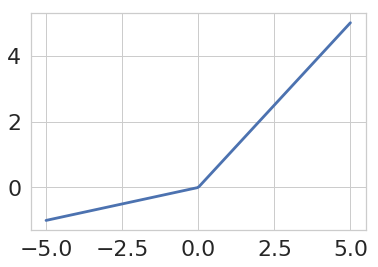

In [15]:
x = np.linspace(-5, 5, 200)
lrelu = np.array([max(0.2 * y, y) for y in x])
plt.plot(x, lrelu)

In [0]:
class MnistDiscriminator(snt.AbstractModule):

  def __init__(self,
               leaky_relu_coeff=0.2, name='MnistDiscriminator'):
    super(MnistDiscriminator, self).__init__(name=name)
    self._leaky_relu_coeff = leaky_relu_coeff

  def _build(self, input_image):
    """Constructs the discriminator graph.

    Args:
      input_image: `tf.Tensor` input to be used by the discriminator.

    Returns:
      `tf.Tensor` output with the decision of the discriminator.
    """
    leaky_relu_activation = lambda x: tf.maximum(self._leaky_relu_coeff * x, x)
    
    conv2d = snt.nets.ConvNet2D(
        output_channels=[8, 16, 32, 64, 128],
        kernel_shapes=[[5, 5]],
        strides=[2, 1, 2, 1, 2],
        paddings=[snt.SAME],
        activate_final=True,
        activation=leaky_relu_activation,
        use_batch_norm=False)

    convolved = conv2d(input_image)
    # Flatten the data to 2D for the classification layer
    flat_data = snt.BatchFlatten()(convolved)
    
    # We have two classes: one for real, and oen for fake data.
    classification_logits = snt.Linear(2)(flat_data)
    return classification_logits


## Generate samples

In [0]:
latents = tf.random_normal((BATCH_SIZE, NUM_LATENTS))
generator = MnistGenerator()
samples = generator(latents)

## Set up the losses


The discriminator is a classifier, so it receives a standard cross entropy loss. The game is given by the value function:
\begin{equation}
\max_{G} \min_{D} \mathbb{E}_{p^*(x)} \log D(x) + \mathbb{E}_{p(z)} \log (1- D(G(z)))
\end{equation}

<h2 align="center"></h2> <img src="http://elarosca.net/gan.png?format=100w" width=210 >



## Discriminator loss

In [0]:
discriminator = MnistDiscriminator()

discriminator_real_data_logits = discriminator(real_data)
discriminator_real_data_labels = tf.ones(shape=BATCH_SIZE, dtype=tf.int32)

real_data_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=discriminator_real_data_logits, labels=discriminator_real_data_labels)

discriminator_samples_logits = discriminator(samples)
discriminator_samples_labels = tf.zeros(shape=BATCH_SIZE, dtype=tf.int32)
samples_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=discriminator_samples_logits, labels=discriminator_samples_labels)

# Reduce loss over batch dimension
discriminator_loss = tf.reduce_mean(real_data_loss + samples_loss)

# Ignore for the first exercise, uncomment if you do the last exercise.
# discriminator_loss += 10 * dragan_penalty_loss(discriminator, real_data)

##  Generator loss
The generator is trying to fool the discriminator. While the min-max loss suggests using $\log (1 - D(G(x)))$ , in practice $- \log D(G(x))$ is used, as it provides better gradients for the generator early in training, when it is performing poorly.



## Let's visualize the two losses and their derivatives

### Original min-max loss.

When using $\log (1 - D(G(x)))$ , as the loss of the generator, we see that the generator does not receive a strong gradient (right plot), when it is doing badly and the discriminator can easily distinguish between samples and real data. But this is not what we want, as early on in training we want the generator to quickly move to generate better samples.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


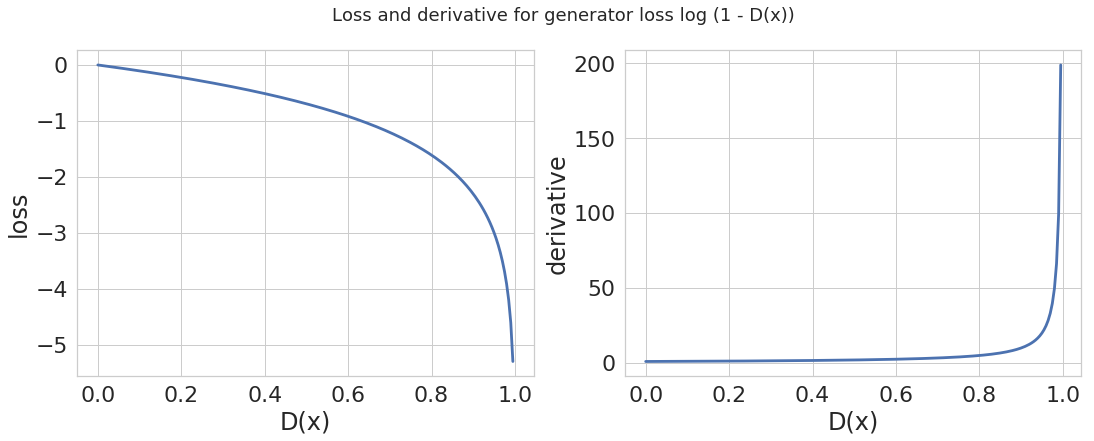

In [22]:
d_x = np.linspace(0.0, 1.0, 200)
loss = np.log(1 - d_x)
grad = 1 / (1 - d_x)

figsize = (18, 6)
fig, axs = plt.subplots(1, 2, figsize=figsize)


# First plot the loss, and then the derivative.
axs[0].plot(d_x, loss, label='log (1 - D(x)')
axs[0].set_xlabel('D(x)')
axs[0].set_ylabel('loss')


axs[1].plot(d_x, grad, label='1 / (1 - D(x)')
axs[1].set_xlabel('D(x)')
axs[1].set_ylabel('derivative')

plt.suptitle('Loss and derivative for generator loss log (1 - D(x))', fontsize=18)

plt.show()

## Alternative loss


When using $-log D(G(x))$ we obtain the desired behaviour: the generator gets strong gradients to move when it is bad at sample generation and the discriminator can easily distinguish between samples and real data.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


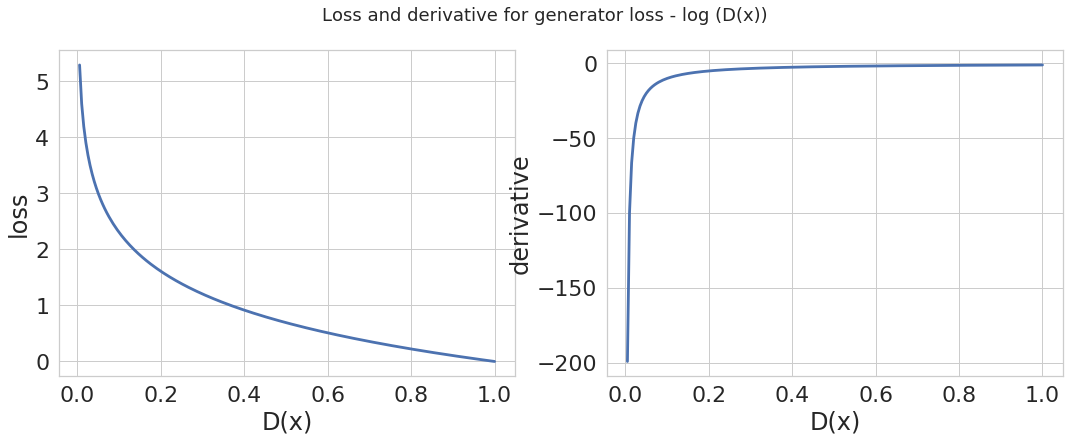

In [24]:
d_g_x = np.linspace(0.0, 1.0, 200)
loss = - np.log(d_g_x)
grad = - 1 / d_g_x

figsize = (18, 6)
fig, axs = plt.subplots(1, 2, figsize=figsize)

# First plot the loss, and then the derivative.
axs[0].plot(d_x, loss, label='- log (D(x)')
axs[0].set_xlabel('D(x)')
axs[0].set_ylabel('loss')


axs[1].plot(d_x, grad, label='1 / (1 - D(x)')
axs[1].set_xlabel('D(x)')
axs[1].set_ylabel('derivative')

plt.suptitle('Loss and derivative for generator loss - log (D(x))', fontsize=18)

plt.show()

### Connections with Jensen Shannon divergence


The GAN paper shows that if the discriminator is optimal, the generator is minimizing the Jensen Shannon divergence between the true data distribution and the generator distribution:

 $$ JSD(p, q) = \frac{1}{2} KL (p || \frac{p+q}{2})  + \frac{1}{2}  KL (q || \frac{p+q}{2})   $$
 
 
 Note that in practice the assumptions required for the proof do not hold:
 
 * the discriminator is not optimal 
      * we do not train the discriminator to optimality, but we do alternating gradient descent (one discriminator update, one generator update).
      * the discriminator is a neural network, which might not have the capacity to estimate the true probabilities.
      * the discriminator does not have access to the entire data distribution (but only a few samples).

## The generator loss

Consider what you have seen above to define the generator loss.

In [0]:
# Get the probabilities from the discriminator logits.
discriminator_probabilities = tf.nn.softmax(discriminator_samples_logits)
# We have to index the discrimiantor output to obtain the probability that the 
# samples are fake.
generator_loss = - tf.log(discriminator_probabilities[:, 1])
generator_loss = tf.reduce_mean(generator_loss)

## Create optimizers and training ops

**Important**: need to pass the list of variables to the TensorFlow optimizer, otherwise the generator and discriminator
variables will receive both the loss of the discrimiantor and that of the generator. 

We want to freeze the discriminator when we update the generator, and vice versa.

In [0]:
discrimiantor_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)
generator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)

# Optimize the discrimiantor.
discriminator_update_op = discrimiantor_optimizer.minimize(
    discriminator_loss, var_list=discriminator.get_all_variables())

# Optimize the generator..
generator_update_op = generator_optimizer.minimize(
    generator_loss, var_list=generator.get_all_variables())

## Create the tensorflow session

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

## Training

We train the discriminator and generator by alternating gradient descent runs. We record the losses to plot them later.

Note: by doing alternating gradient descent we are not solving the original min max problem, which requires training the discrimininator to optimaility in the inner loop.

In [0]:
disc_losses = []
gen_losses = []

for i in xrange(TRAINING_STEPS):
  sess.run(discriminator_update_op)
  sess.run(generator_update_op)
  
  if i % 100 == 0: 
    disc_loss = sess.run(discriminator_loss)
    gen_loss = sess.run(generator_loss)    
  
    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)
    
    print('At iteration {} out of {}'.format(i, TRAINING_STEPS))

## Visualize the behaviour of the two losses during training

Note that unlike losses for classifiers, or for VAEs, the losses are not stable and are going up and down, depending on the training dynamics. 

Text(0.5,-0.2,u'Generator loss')

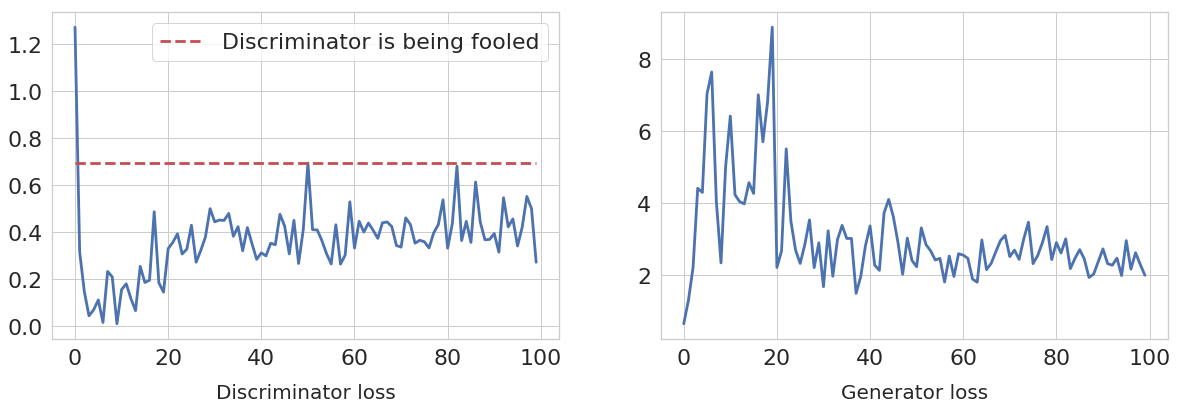

In [31]:
figsize = (20, 6)
fig, axs = plt.subplots(1, 2, figsize=figsize)


# First plot the loss, and then the derivative.
axs[0].plot(disc_losses, '-')
axs[0].plot([np.log(2)] * len(disc_losses), 'r--', label='Discriminator is being fooled')
axs[0].legend()
axs[0].set_title('Discriminator loss', fontsize=20, y=-0.2)
axs[1].plot(gen_losses, '-')
axs[1].set_title('Generator loss', fontsize=20, y=-0.2)

## Visualize training results

After we have trained the discriminator and the generator, we can visualize the samples obtained from the generator, and compare them with real data samples.

In [0]:
def gallery(array, ncols=10, rescale=True):
  """Code adapted from: https://stackoverflow.com/questions/42040747/more-idomatic-way-to-display-images-in-a-grid-with-numpy"""
    if rescale:
      array = (array + 1.) / 2
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

In [0]:
real_data_examples = sess.run(real_data)
final_samples = sess.run(samples)

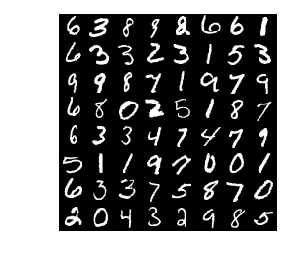

In [27]:
plt.gray()
plt.axis('off')
plt.imshow(gallery(real_data_examples, ncols=8).squeeze(axis=2))

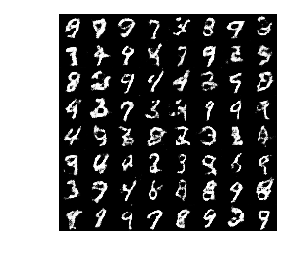

In [28]:
plt.gray()
plt.axis('off')
plt.imshow(gallery(final_samples, ncols=8).squeeze(axis=2))

## Interpolate between latent space vectors to see latent space traversal

By doing an interpolation in latent space, we can analyze the behaviour of the model. This allows us to see that the model generalizes in different parts of the space, and test how it "moves" from one digit to the next.

In [0]:
a = np.linspace(0.0, 1.0, 100)
a = np.expand_dims(a, axis=1)

first_latents = tf.random_normal((1, NUM_LATENTS))
second_latents = tf.random_normal((1, NUM_LATENTS))

# To ensure that the interpolation is still likely under the Gaussian prior,
# we use Gaussian interpolation - rather than linear interpolation.
interpolations =  np.sqrt(a) * first_latents + np.sqrt(1 - a) * second_latents

samples_from_interpolations = generator(interpolations)

In [0]:
samples_from_interpolations_np = sess.run(samples_from_interpolations)

In [31]:
print(samples_from_interpolations_np.shape)

(100, 28, 28, 1)


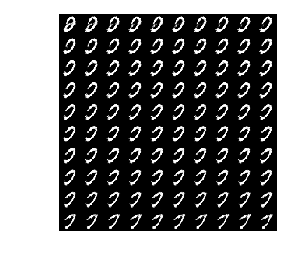

In [32]:
plt.gray()
plt.axis('off')
plt.imshow(gallery(samples_from_interpolations_np).squeeze(axis=2))
plt.show()

### Difference with VAE latent traversal

Do you notice a difference between VAE and GAN latent traversal results?

### Exercise: Try to do 5 discriminator updates per generator update.

---



### [Optional] Gradient penalties

Add the DRAGAN gradient penalty to the discriminator loss. For more details, see: https://arxiv.org/pdf/1705.07215.pdf. For more information on gradient penalties, see: https://arxiv.org/abs/1710.08446.

You want to ensure add a penalty that the gradients of the discriminator around the data are 1. 

What you have to do:

1) Create a noised version of the data, by adding zero mean noise, with a small std (something like 0.5 * the standard deviation of the input data batch).

2) Take the gradients of the discriminator with respect to these interpolations.

3) Take the norm over the batch over these gradients - this should return a vector of size `batch_size`

4) Return the square loss between the obtained average gradients and 1.



In [0]:
def batch_l2_norms(x, eps=1e-5):
  reduction_axis = range(1, x.get_shape().ndims)
  squares = tf.reduce_sum(tf.square(x), axis=reduction_axis)
  squares.get_shape().assert_is_compatible_with([None])
  return tf.sqrt(eps + squares)


def dragan_penalty_loss(discriminator, real_data):
  """The gradient penalty loss on noisy data.

  Proposed by https://arxiv.org/pdf/1705.07215.pdf

  Args:
    discriminator: An instance of `AbstractDiscriminator`.
    real_data: A `tf.Tensor` (joint discriminator `tf.Tensor` sequences are not
      yet supported). The data associated as real by the GAN, usually from a
      datasets. Needs to be a valid input for `discriminator`.
  Returns:
    A tf.Tensor scalar, containing the loss.
  """
  batch_size = tf.shape(real_data)[0]

  # Adapted to TF from the original code here:
  # https://github.com/kodalinaveen3/DRAGAN/blob/master/DRAGAN.ipynb
  _, var = tf.nn.moments(
      real_data, axes=list(xrange(len(real_data.get_shape()))))
  std = tf.sqrt(var)
  noisy_data = real_data + 0.5 * std * tf.random_uniform(
      shape=tf.shape(real_data))

  # Coefficient for the linear interpolation.
  data_dim = len(real_data.shape)
  alpha_shape = [batch_size] + [1] * (data_dim - 1)
  alpha = tf.random_uniform(shape=alpha_shape, minval=0., maxval=1.)
  interpolation = real_data + alpha * (noisy_data - real_data)
  # Compute the gradients wrt to the output of the discriminator / critic.
  # Note that the outputs can be more than one dimensional, in the case the
  # penalty will be the mean of the penalties of each individual output units
  # of the critic.
  grads = tf.gradients(
      discriminator(interpolation), [interpolation])[0]
  slopes = batch_l2_norms(grads)
  return tf.reduce_mean((slopes - 1)**2)


Change the discriminator loss from the original cell.

Add to `dragan_penalty_loss(discriminator, real_data)` to `discriminator_loss` with a coefficient of 10.

## Close session

In [0]:
sess.close()

### Reflections

* are GANs doing divergence minimization?
* how are GANs different to VAEs?


### GAN samples on other datasets

Note: these are samples with the vanilla algorithm, but they can be improved using better complex distributions.


#### CIFAR-10

<h2 align="center"></h2> <img src="http://elarosca.net/cifar-dcgan.png?format=100w" width=500 >

#### CelebA

<h2 align="center"></h2> <img src="http://elarosca.net/celeba_dcgan_latest.png?format=100w" width=500 >